<a href="https://colab.research.google.com/github/dakyommii/study/blob/main/yolo/trafficCustomYoloDetectionTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
!cp -r /gdrive/MyDrive/darknet/trafficsign/ .

In [ ]:
!ls -al ./trafficsign/

total 515320
drwx------ 4 root root      4096 Mar 30 02:16 .
drwxr-xr-x 1 root root      4096 Mar 30 02:15 ..
-rw------- 1 root root   3264016 Mar 30 02:15 00000.ppm
-rw------- 1 root root   3264016 Mar 30 02:15 00001.ppm
-rw------- 1 root root        34 Mar 30 02:15 classes.names
drwx------ 2 root root      4096 Mar 30 02:16 Meta
drwx------ 2 root root      4096 Mar 30 02:16 Test
-rw------- 1 root root    427897 Mar 30 02:15 Test.csv
-rw------- 1 root root       855 Mar 30 02:15 traffic-classes.names
-rw------- 1 root root  19616272 Mar 30 02:16 traffic_sign.h5
-rw------- 1 root root   8310391 Mar 30 02:16 traffic-sign-video.mp4
-rw------- 1 root root      8328 Mar 30 02:16 traffic-sign-yolo.cfg
-rw------- 1 root root 246370008 Mar 30 02:16 traffic-sign-yolo_final.weights
-rw------- 1 root root      8328 Mar 30 02:15 traffic-train-yolo.cfg
-rw------- 1 root root 246370008 Mar 30 02:15 traffic-train-yolo_final.weights


In [ ]:
weight_file = './trafficsign/traffic-sign-yolo_final.weights'
cfg_file = './trafficsign/traffic-sign-yolo.cfg'
name_file = './trafficsign/classes.names'

min_confidence = 0.5

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import IPython  #
import time

In [ ]:
frame_count = 0
writer = None
input_name = './trafficsign/traffic-sign-video.mp4'
output_name = 'traffic-sign-video.avi'
file_name = './trafficsign/00000.ppm'

In [ ]:
# Load Yolo
net = cv2.dnn.readNet(weight_file, cfg_file)

layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [ ]:
classes = []
with open(name_file, 'r') as f:
    classes = [line.strip() for line in f.readlines()]
print(classes)

['Prohibitory', 'Danger', 'Mandatory', 'Other']


1 Danger


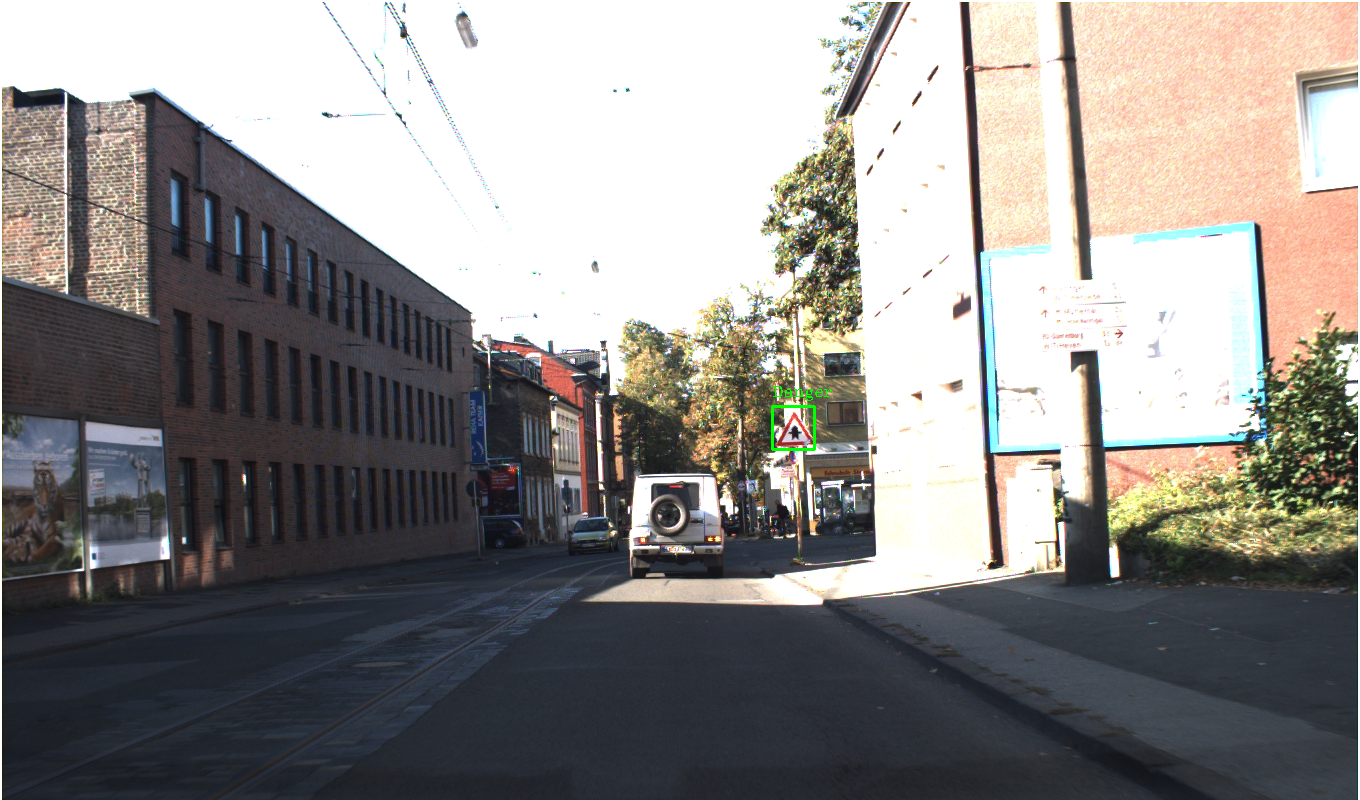

In [ ]:
img = cv2.imread(file_name)
height, width, channels = img.shape
# Detecting objects
# https://docs.opencv.org/master/d6/d0f/group__dnn.html
blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

net.setInput(blob)
outs = net.forward(output_layers)

class_ids = []
confidences = []
boxes = []

for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > min_confidence:
            # Object detected
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)

            # Rectangle coordinates
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)

            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

indexes = cv2.dnn.NMSBoxes(boxes, confidences, min_confidence, 0.4)
font = cv2.FONT_HERSHEY_COMPLEX
for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        print(class_ids[i], label)
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(img, label, (x, y - 10), font, 0.5, (0, 255, 0), 1)  

cv2_imshow(img)  

#2. Video Detection

In [ ]:
#동영상 없으면 만들어주기
def writeFrame(img):
    # use global variable, writer
    global writer
    height, width = img.shape[:2]
    if writer is None and output_name is not None:
        fourcc = cv2.VideoWriter_fourcc(*'MJPG')
        writer = cv2.VideoWriter(output_name, fourcc, 24, (width, height), True)
    if writer is not None:
        writer.write(img)

In [ ]:
def detectAndDisplay(frame):
    # use global variable, writer
    global frame_count
    frame_count += 1
    start_time = time.time()
    IPython.display.clear_output(wait=True)
    height, width, channedls = frame.shape
    # Detecting objects
    # https://docs.opencv.org/master/d6/d0f/group__dnn.html
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

    net.setInput(blob)
    outs = net.forward(output_layers)

    class_ids = []
    confidences = []
    boxes = []

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > min_confidence:
                # Object detected
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # Rectangle coordinates
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, min_confidence, 0.4)
    font = cv2.FONT_HERSHEY_COMPLEX
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            print(class_ids[i], label)
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(frame, label, (x, y - 10), font, 0.5, (0, 255, 0), 1)  

    #프레임 시간 체크
    frame_time = time.time() - start_time 
    print("Frame {} time {}".format(frame_count, frame_time))
    cv2_imshow(frame)   
    writeFrame(frame)

0 Prohibitory
0 Prohibitory
Frame 165 time 2.2132837772369385


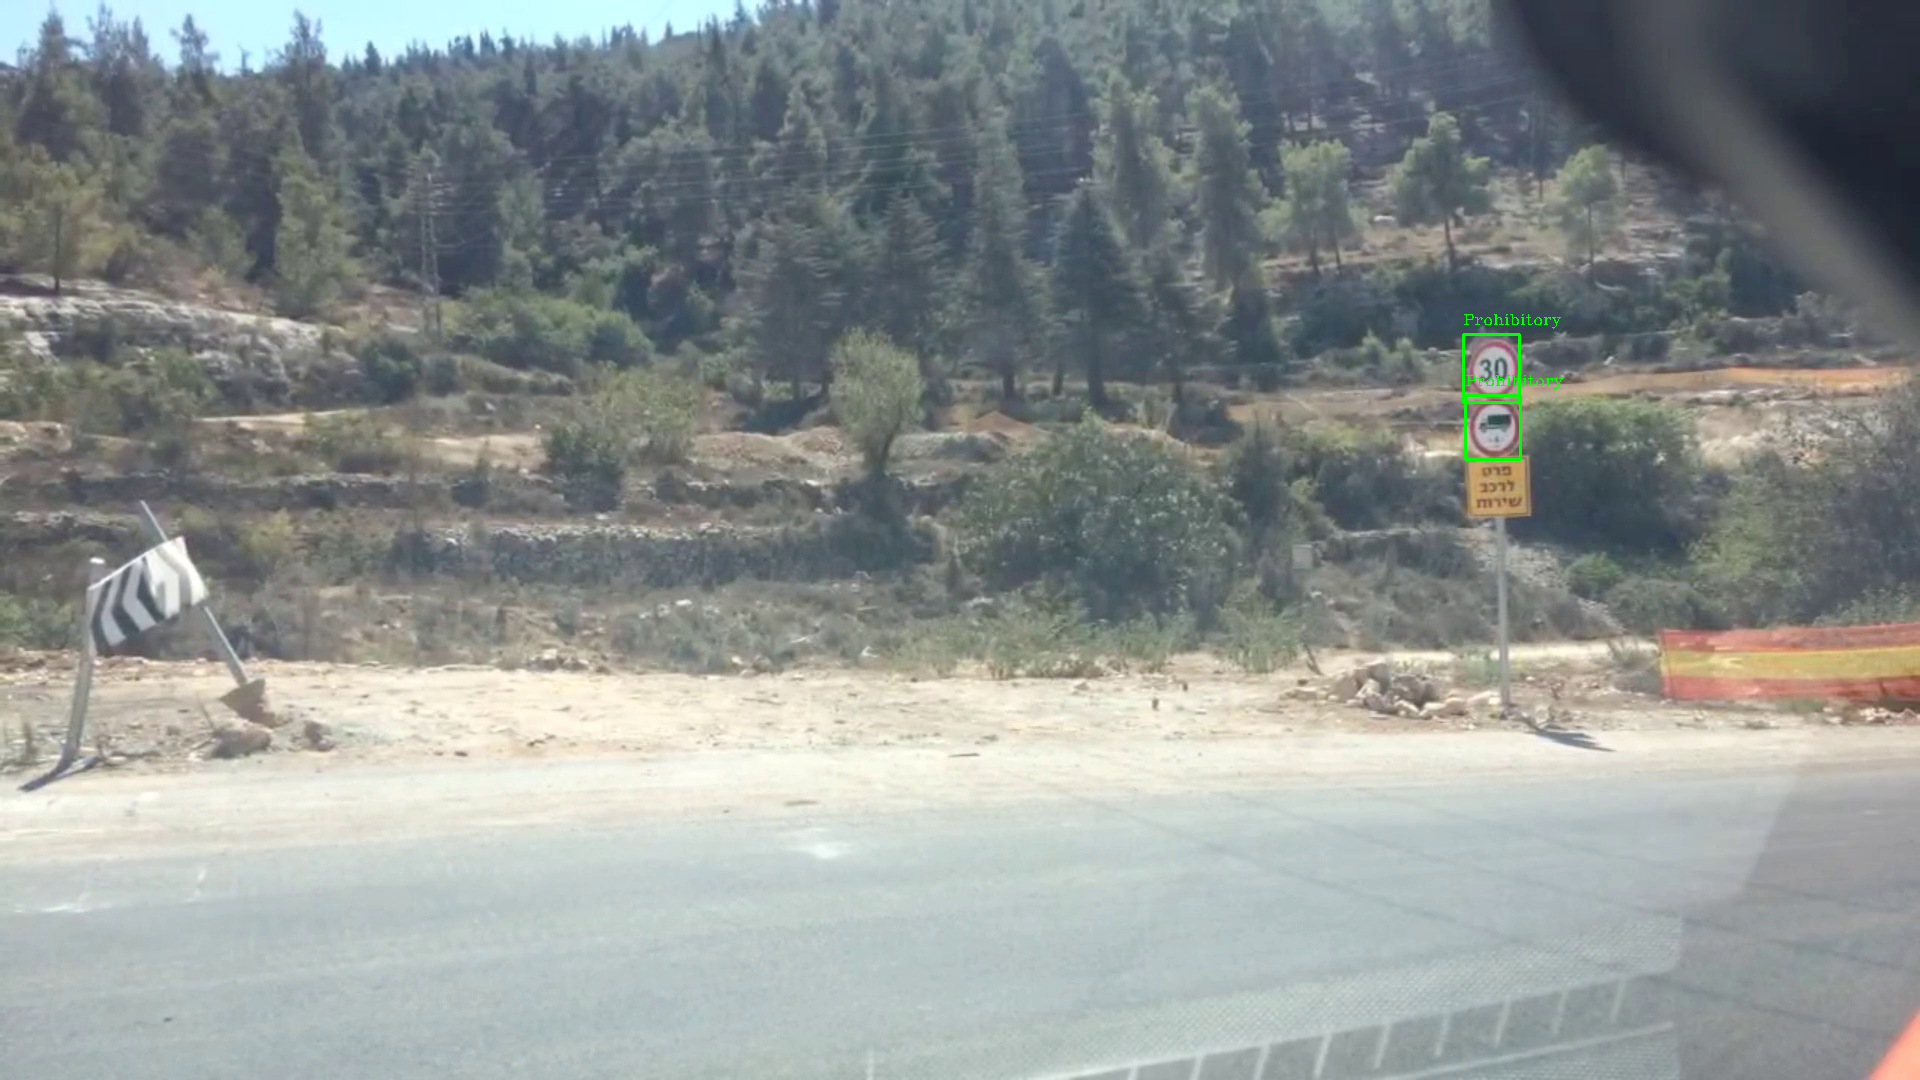

--(!) No captured frame -- Break!


In [ ]:
#-- 2. Read the video stream
#동영상 실행해서 detection
cap = cv2.VideoCapture(input_name)
if not cap.isOpened:
    print('--(!)Error opening video capture')
    exit(0)
while True:
    ret, frame = cap.read()
    if frame is None:
        print('--(!) No captured frame -- Break!')
        break
    detectAndDisplay(frame)

In [ ]:
#동영상 다운로드
from google.colab import files
files.download(output_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>